# Scrap and Sentiment Analysis of Halodoc Reviews App

### Naura Jasmine Azzahra
### 5026211005

# Import Library

In [2]:
  !pip install google_play_scraper
!pip install textblob
from google_play_scraper import app, Sort, reviews_all
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

C:\Users\User\AppData\Local\Temp\ipykernel_38144\3706398329.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


#Data Preprocessing

In [3]:
#Android App Halodoc link from Google Play at
#https://play.google.com/store/apps/details?id=com.linkdokter.halodoc.android
#The apps ID found in the link after id=com.linkdokter.halodoc.android
#The apps name on Google Play titled: Halodoc : Dokter, Obat, & Lab
#Dated 29 August 2024: number of reviews 450k++

from google_play_scraper import app, Sort, reviews_all

halodoc_reviews = reviews_all(
    'com.linkdokter.halodoc.android',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [4]:
#Save the Halodoc Apps reviews into dataframe
df_hdrev = pd.DataFrame(np.array(halodoc_reviews),columns=['content'])
df_hdrev = df_hdrev.join(pd.DataFrame(df_hdrev.pop('content').tolist()))
df_hdrev.to_csv(r'df_halodoc.csv', index=False)
df_hdrev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,482274f3-08bb-46ee-a911-a613476563b9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat penting dan di butuhkan,5,0,22.600,2024-09-08 21:03:01,Hai Caleb Nikao Hutabarat! Terima kasih sudah ...,2024-09-09 01:32:51,22.600
1,cbe22d87-5de9-4938-9291-3ba4f30e21de,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Good,5,0,22.600,2024-09-08 17:31:24,Hai kiyo nala! Terima kasih sudah menggunakan ...,2024-09-08 19:33:57,22.600
2,b1b79138-c93c-49a6-8aa0-5f27e97b2fff,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Good,4,0,22.600,2024-09-08 16:03:02,Hai RimaR Septaviani! Terima kasih sudah mengg...,2024-09-08 16:11:54,22.600
3,ad7bd5df-7be0-4961-8fae-2f70cfe8b6ec,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Apps ini sangat membantu utk berobat tanpa har...,5,0,22.600,2024-09-08 14:38:18,Hai Shandy Marpaung! Terima kasih sudah menggu...,2024-09-08 15:18:12,22.600
4,e4f7a9bc-271d-49e6-88ce-ea66cbde6bbe,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat membantu,5,0,22.600,2024-09-08 13:52:43,Hai Alfred Andreas! Terima kasih sudah menggun...,2024-09-08 14:38:18,22.600


In [5]:
#Information on the table
df_hdrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35929 entries, 0 to 35928
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              35929 non-null  object        
 1   userName              35929 non-null  object        
 2   userImage             35929 non-null  object        
 3   content               35929 non-null  object        
 4   score                 35929 non-null  int64         
 5   thumbsUpCount         35929 non-null  int64         
 6   reviewCreatedVersion  32692 non-null  object        
 7   at                    35929 non-null  datetime64[ns]
 8   replyContent          35926 non-null  object        
 9   repliedAt             35926 non-null  datetime64[ns]
 10  appVersion            32692 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 3.0+ MB


In [6]:
df_hdrev.loc[:,["content","score"]]

,content,score
0,Sangat penting dan di butuhkan,5
1,Good,5
2,Good,4
3,Apps ini sangat membantu utk berobat tanpa har...,5
4,Sangat membantu,5
...,...,...
35924,It's very easy and helpful,5
35925,Sepertinya ini aplikasi pertama di Indonesia.....,5
35926,Good aplication,5
35927,This is simplying health,5


##Translate to English


In [7]:
# return unique valuefrom df
print(df_hdrev.reviewCreatedVersion.unique())
print(df_hdrev.reviewCreatedVersion.nunique())

['22.600' None '22.502' '16.813' '22.100' '21.900' '22.400' '18.900'
 '22.200' '22.301' '22.000' '21.700' '21.800' '20.300' '21.400' '21.510'
 '21.500' '21.210' '21.301' '21.600' '21.200' '14.401' '20.601' '15.100'
 '6.501' '20.501' '20.900' '21.100' '20.801' '20.700' '21.001' '20.100'
 '13.900' '16.602' '20.800' '20.510' '20.202' '17.303' '20.400' '20.001'
 '19.900' '19.600' '19.501' '13.301' '20.201' '11.510' '19.801' '19.402'
 '19.701' '18.002' '18.610' '19.300' '19.700' '11.902' '18.800' '19.000'
 '19.101' '17.000' '19.200' '18.300' '17.202' '16.510' '19.210' '16.100'
 '19.100' '15.000' '18.701' '18.600' '18.101' '18.510' '17.502' '18.700'
 '18.501' '17.703' '18.201' '10.701' '17.100' '17.902' '17.901' '17.602'
 '9.900' '17.802' '16.900' '17.302' '17.701' '17.601' '17.101' '17.501'
 '6.200' '14.900' '16.812' '16.111' '16.401' '16.411' '16.811' '16.701'
 '16.601' '7.010' '16.501' '11.500' '12.800' '16.112' '11.600' '16.301'
 '16.202' '16.110' '15.801' '16.201' '9.301' '16.001' '15.7

In [8]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_hdrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,Sangat penting dan di butuhkan,5,0,22.600,2024-09-08 21:03:01,Hai Caleb Nikao Hutabarat! Terima kasih sudah ...,2024-09-09 01:32:51
1,Good,5,0,22.600,2024-09-08 17:31:24,Hai kiyo nala! Terima kasih sudah menggunakan ...,2024-09-08 19:33:57
2,Good,4,0,22.600,2024-09-08 16:03:02,Hai RimaR Septaviani! Terima kasih sudah mengg...,2024-09-08 16:11:54
3,Apps ini sangat membantu utk berobat tanpa har...,5,0,22.600,2024-09-08 14:38:18,Hai Shandy Marpaung! Terima kasih sudah menggu...,2024-09-08 15:18:12
4,Sangat membantu,5,0,22.600,2024-09-08 13:52:43,Hai Alfred Andreas! Terima kasih sudah menggun...,2024-09-08 14:38:18
...,...,...,...,...,...,...,...
35924,It's very easy and helpful,5,2,None,2016-04-02 12:54:34,Hai! Terima kasih sudah menggunakan Halodoc. J...,2019-12-16 08:16:39
35925,Sepertinya ini aplikasi pertama di Indonesia.....,5,4,0.16.2-build201603301019,2016-04-02 11:06:15,Hai! Terima kasih sudah menggunakan Halodoc. J...,2019-12-16 08:19:05
35926,Good aplication,5,1,0.16.2-build201603301019,2016-04-02 11:02:41,Hai! Terima kasih sudah menggunakan Halodoc. J...,2019-12-16 08:19:03
35927,This is simplying health,5,1,0.13.1-build201603171038,2016-03-18 19:11:25,Hai! Terima kasih sudah menggunakan Halodoc. J...,2019-12-16 08:17:08


In [11]:
#Ambil Sampel Acak 1000 data
import pandas as pd

df_hdrev.info()

# Ambil 1.000 data acak dari DataFrame
df_hdrev = df_hdrev.sample(n=1000)

# Periksa hasil sampling
print(df_hdrev.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35929 entries, 0 to 35928
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              35929 non-null  object        
 1   userName              35929 non-null  object        
 2   userImage             35929 non-null  object        
 3   content               35929 non-null  object        
 4   score                 35929 non-null  int64         
 5   thumbsUpCount         35929 non-null  int64         
 6   reviewCreatedVersion  32692 non-null  object        
 7   at                    35929 non-null  datetime64[ns]
 8   replyContent          35926 non-null  object        
 9   repliedAt             35926 non-null  datetime64[ns]
 10  appVersion            32692 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 16286 to 

In [12]:
!pip3 install deep_translator
from deep_translator import GoogleTranslator

def translate_id_to_eng(text):
    translated = GoogleTranslator(source='id', target='en').translate(text)
    return translated


df_hdrev['content'] = df_hdrev['content'].apply(lambda x: translate_id_to_eng(x))
df_hdrev['content'] = df_hdrev['content'].fillna('')

In [13]:
!pip install emoji
!pip install wordcloud

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

## Step 1 - Sentiment Polarity and Subjective Before Preprocessing

In [16]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_hdrev['sentiment_polarity'] = df_hdrev['content'].apply(lambda x: TextBlob(x).polarity)
df_hdrev['sentiment_subjective'] = df_hdrev['content'].apply(lambda x: TextBlob(x).subjectivity)

In [18]:
#df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","at"]]
df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
16286,Nice and helpful doctor...God bless,5,0.600000,1.000000
26624,Good,5,0.700000,0.600000
24905,Good. Very helpful,5,0.450000,0.450000
13360,"Communicative doctor, have used this application several times. Treatment is quite targeted",5,0.000000,0.000000
96,The best way to consult a doctor in an emergency or when you can't leave the house,5,1.000000,0.300000
...,...,...,...,...
6405,"I complained via chat for a long time without any answer, when they answered they just repeated my question. For example: Why is the recipe not right? Answered Why is the recipe not right And so o...",1,-0.089286,0.328571
24058,"very helpful for people who have minimal knowledge about the world of health, the doctors are very fast in serving the session. love it.",5,0.215000,0.570000
26140,very helpful,5,0.200000,0.300000
9715,All processes went smoothly. Quick response.,5,0.333333,0.500000


In [19]:
#Check number of reviews scores
df_hdrev['score'].value_counts()

score
5    816
1     80
4     59
3     27
2     18
Name: count, dtype: int64

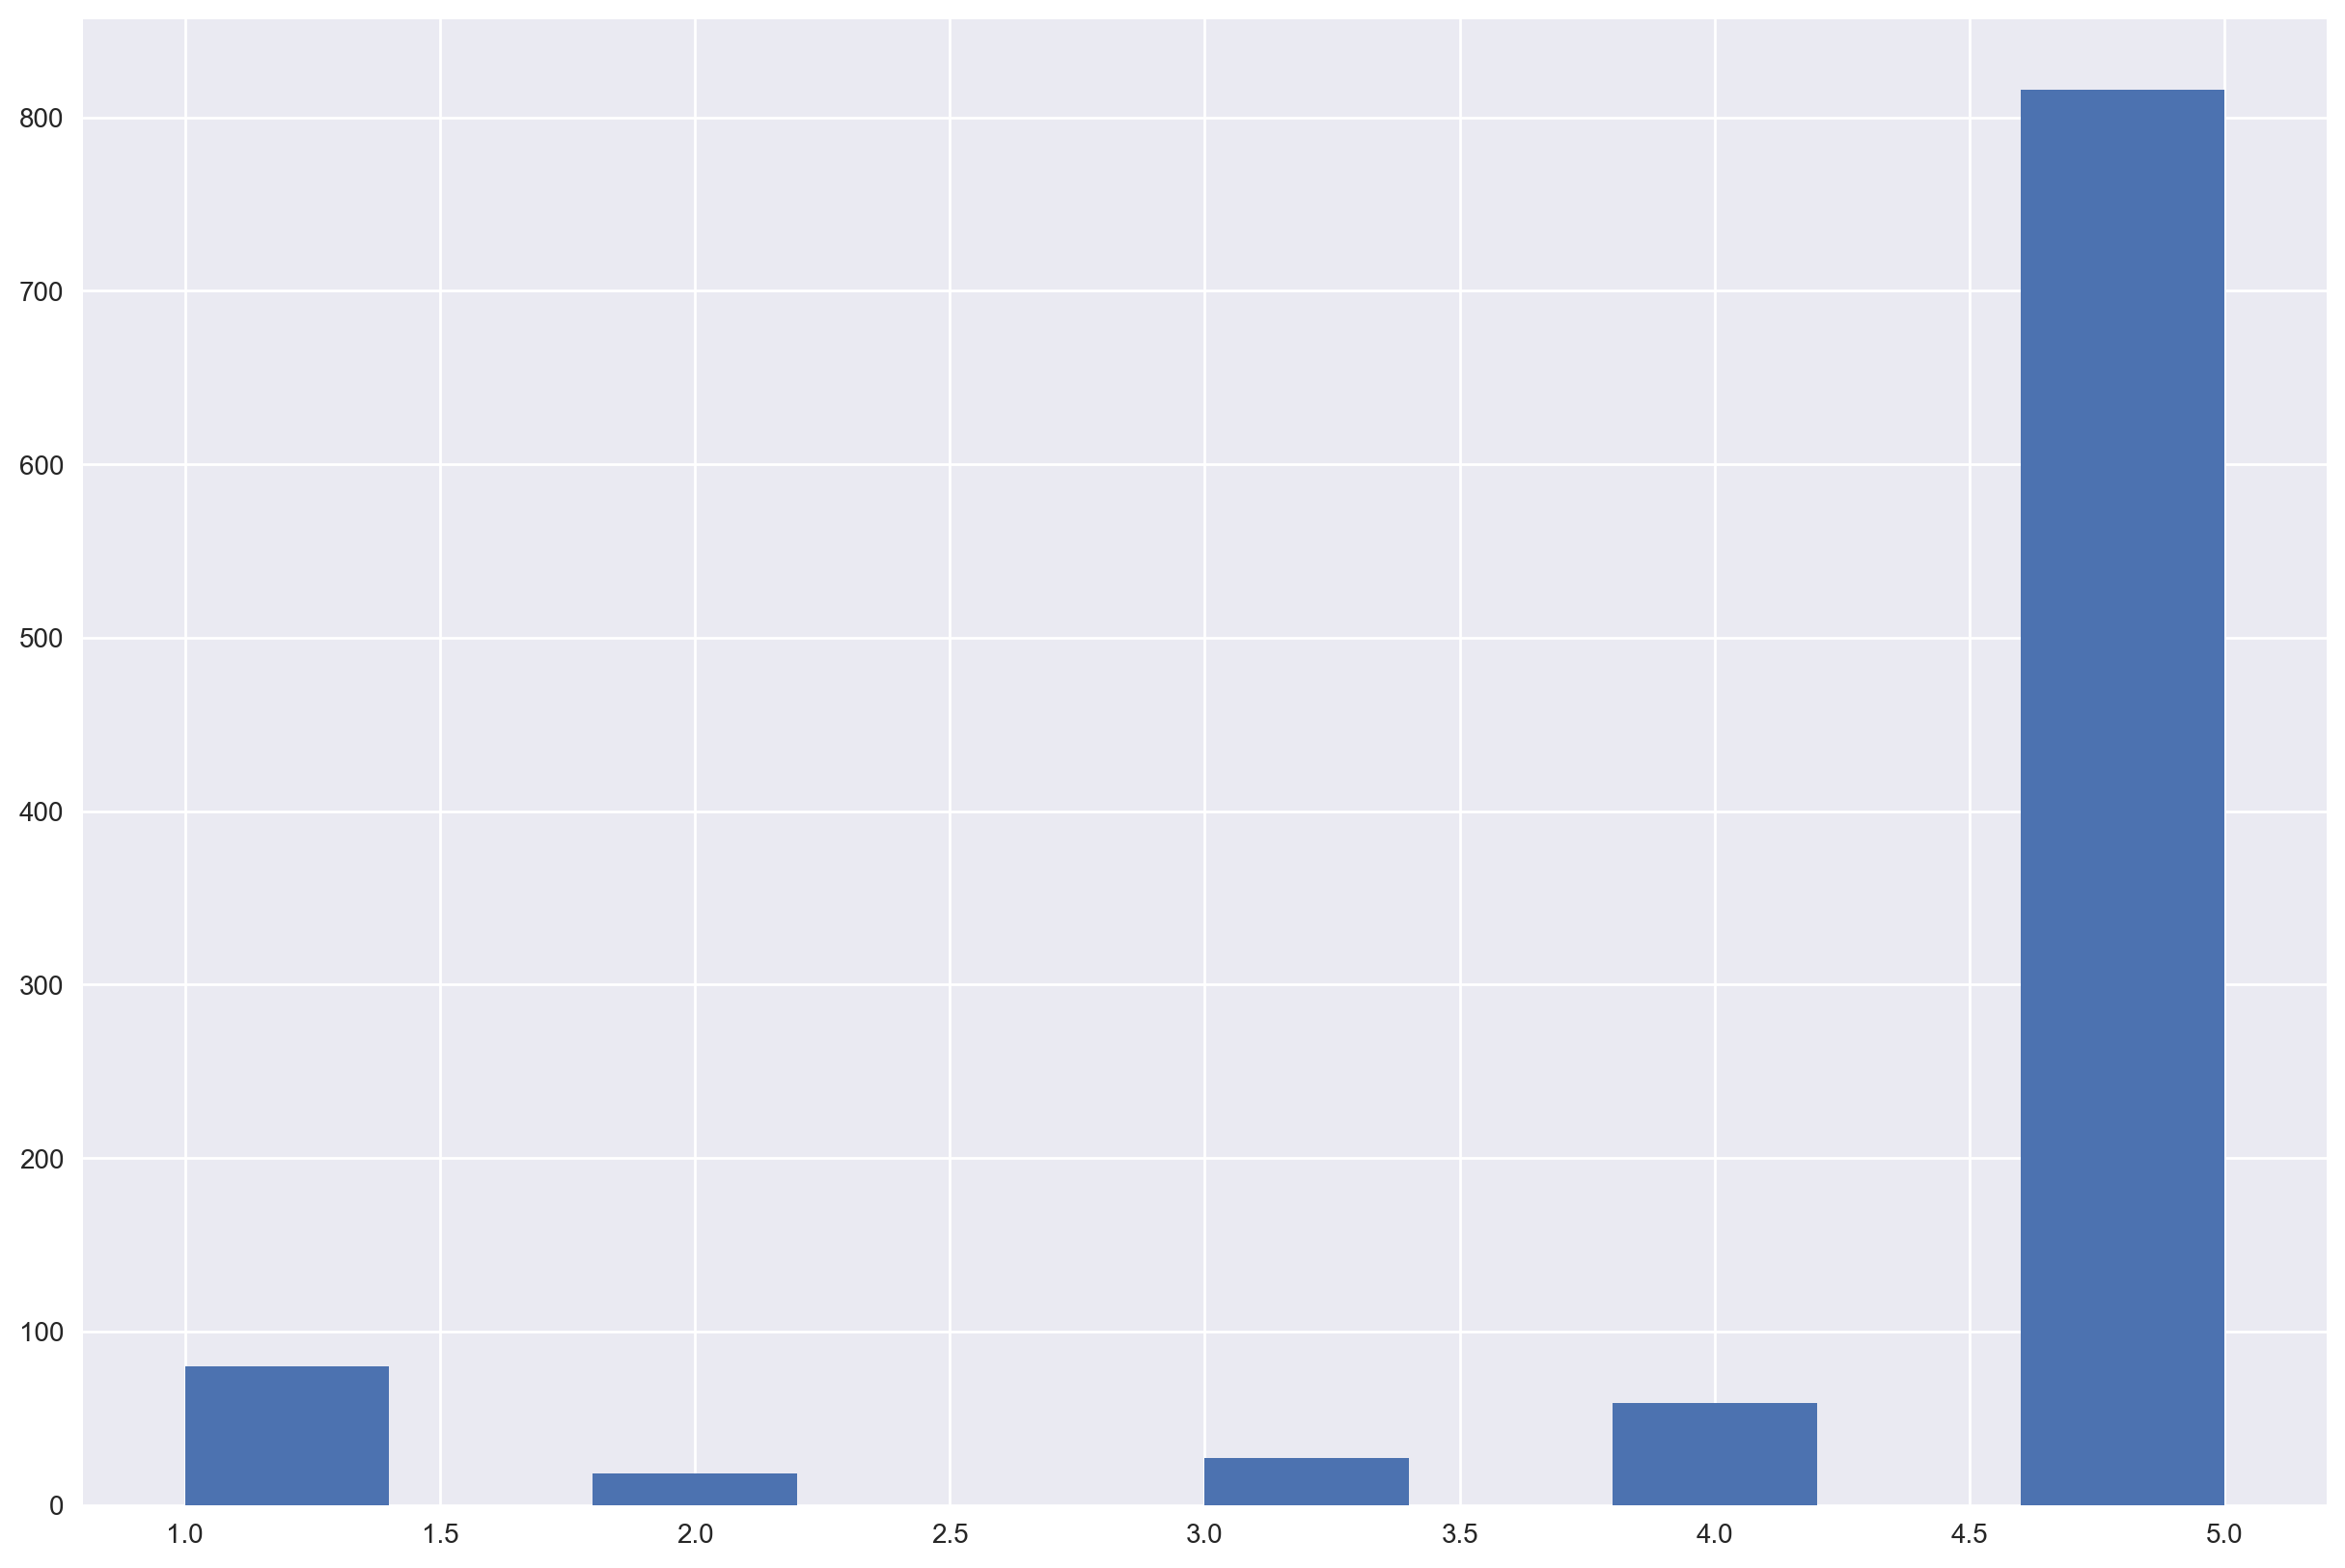

In [20]:
plt.hist(df_hdrev['score'])
plt.show()

## Step 2 - Lower Case the Content

In [23]:
# Lower casing


# Change the reviews type to string
df_hdrev['content'] = df_hdrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_hdrev['content'])

16286                                                                                                                                                                        Nice and helpful doctor...God bless
26624                                                                                                                                                                                                       Good
24905                                                                                                                                                                                         Good. Very helpful
13360                                                                                                                Communicative doctor, have used this application several times. Treatment is quite targeted
96                                                                                                                            The best way to consult a doctor in an

In [25]:
#Lowercase all reviews to see the difference
df_hdrev['content']= df_hdrev['content'].apply(lambda x: x.lower())
print(df_hdrev['content'])

16286                                                                                                                                                                        nice and helpful doctor...god bless
26624                                                                                                                                                                                                       good
24905                                                                                                                                                                                         good. very helpful
13360                                                                                                                communicative doctor, have used this application several times. treatment is quite targeted
96                                                                                                                            the best way to consult a doctor in an

In [26]:
# Analyze the content statistic
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_hdrev['wordCount'] = [len(review.split()) for review in df_hdrev['content']]

df_hdrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_hdrev['content']]

df_hdrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_hdrev['content']]

In [27]:
df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
16286,nice and helpful doctor...god bless,5,0.600000,1.000000,5,0,3
26624,good,5,0.700000,0.600000,1,0,0
24905,good. very helpful,5,0.450000,0.450000,3,0,1
13360,"communicative doctor, have used this application several times. treatment is quite targeted",5,0.000000,0.000000,12,0,2
96,the best way to consult a doctor in an emergency or when you can't leave the house,5,1.000000,0.300000,17,0,1
...,...,...,...,...,...,...,...
6405,"i complained via chat for a long time without any answer, when they answered they just repeated my question. for example: why is the recipe not right? answered why is the recipe not right and so o...",1,-0.089286,0.328571,45,0,4
24058,"very helpful for people who have minimal knowledge about the world of health, the doctors are very fast in serving the session. love it.",5,0.215000,0.570000,24,0,3
26140,very helpful,5,0.200000,0.300000,2,0,0
9715,all processes went smoothly. quick response.,5,0.333333,0.500000,6,0,2


In [28]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [29]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

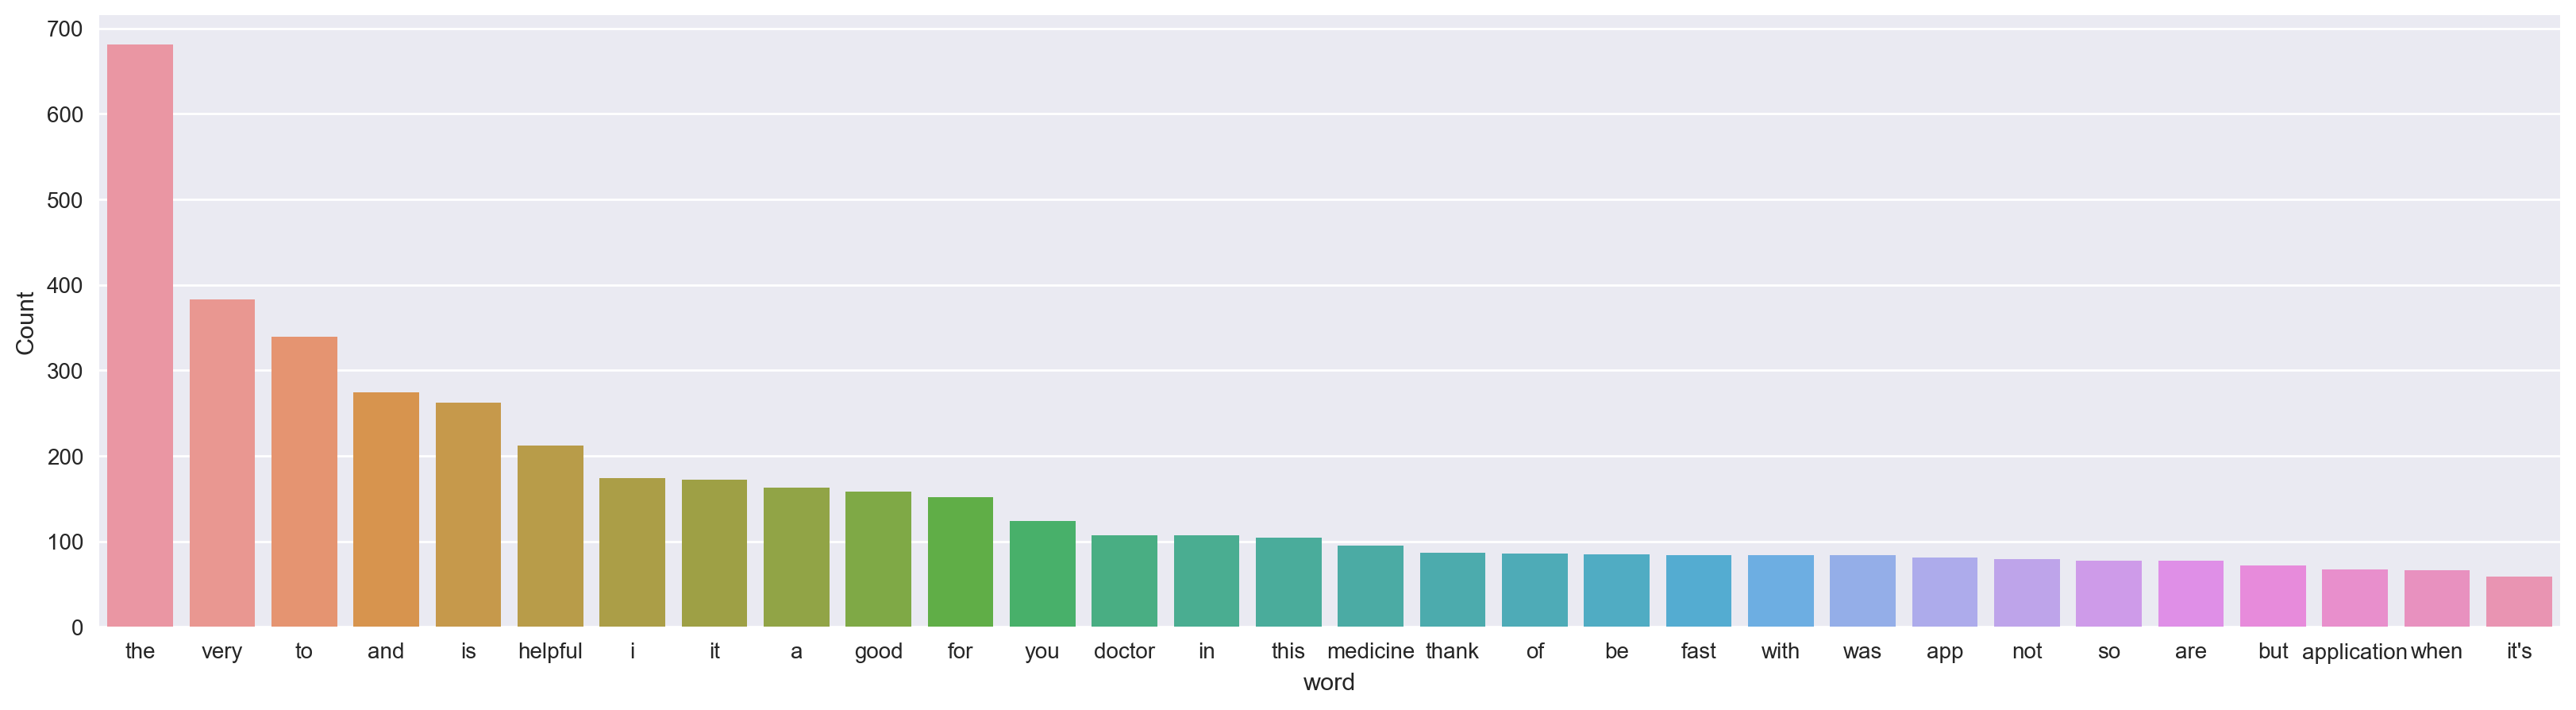

In [30]:
freq_words(df_hdrev['content'])

## Step 3 - Remove Special Characters / cleaning the text

In [31]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_hdrev.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return expe.findall(s)
    return expe.sub(r'',s)

for y in df_hdrev['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))

print(extracted_emojis)

True
['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😧']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😅']", '[]', '[]', '[]', "['🙏', '🙏', '🙏', '🙏']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍', '👍', '👍', '🤭']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", '[]', "['👍', '🏼']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[

In [32]:
df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
16286,nice and helpful doctor...god bless,5,0.600000,1.000000,5,0,3
26624,good,5,0.700000,0.600000,1,0,0
24905,good. very helpful,5,0.450000,0.450000,3,0,1
13360,"communicative doctor, have used this application several times. treatment is quite targeted",5,0.000000,0.000000,12,0,2
96,the best way to consult a doctor in an emergency or when you can't leave the house,5,1.000000,0.300000,17,0,1
...,...,...,...,...,...,...,...
6405,"i complained via chat for a long time without any answer, when they answered they just repeated my question. for example: why is the recipe not right? answered why is the recipe not right and so o...",1,-0.089286,0.328571,45,0,4
24058,"very helpful for people who have minimal knowledge about the world of health, the doctors are very fast in serving the session. love it.",5,0.215000,0.570000,24,0,3
26140,very helpful,5,0.200000,0.300000,2,0,0
9715,all processes went smoothly. quick response.,5,0.333333,0.500000,6,0,2


In [33]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_hdrev['sentiment_rating'] = df_hdrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [34]:
df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
16286,nice and helpful doctor...god bless,5,0.600000,1.000000,Positive
26624,good,5,0.700000,0.600000,Positive
24905,good. very helpful,5,0.450000,0.450000,Positive
13360,"communicative doctor, have used this application several times. treatment is quite targeted",5,0.000000,0.000000,Positive
96,the best way to consult a doctor in an emergency or when you can't leave the house,5,1.000000,0.300000,Positive
...,...,...,...,...,...
6405,"i complained via chat for a long time without any answer, when they answered they just repeated my question. for example: why is the recipe not right? answered why is the recipe not right and so o...",1,-0.089286,0.328571,Negative
24058,"very helpful for people who have minimal knowledge about the world of health, the doctors are very fast in serving the session. love it.",5,0.215000,0.570000,Positive
26140,very helpful,5,0.200000,0.300000,Positive
9715,all processes went smoothly. quick response.,5,0.333333,0.500000,Positive


C:\Users\User\anaconda3\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


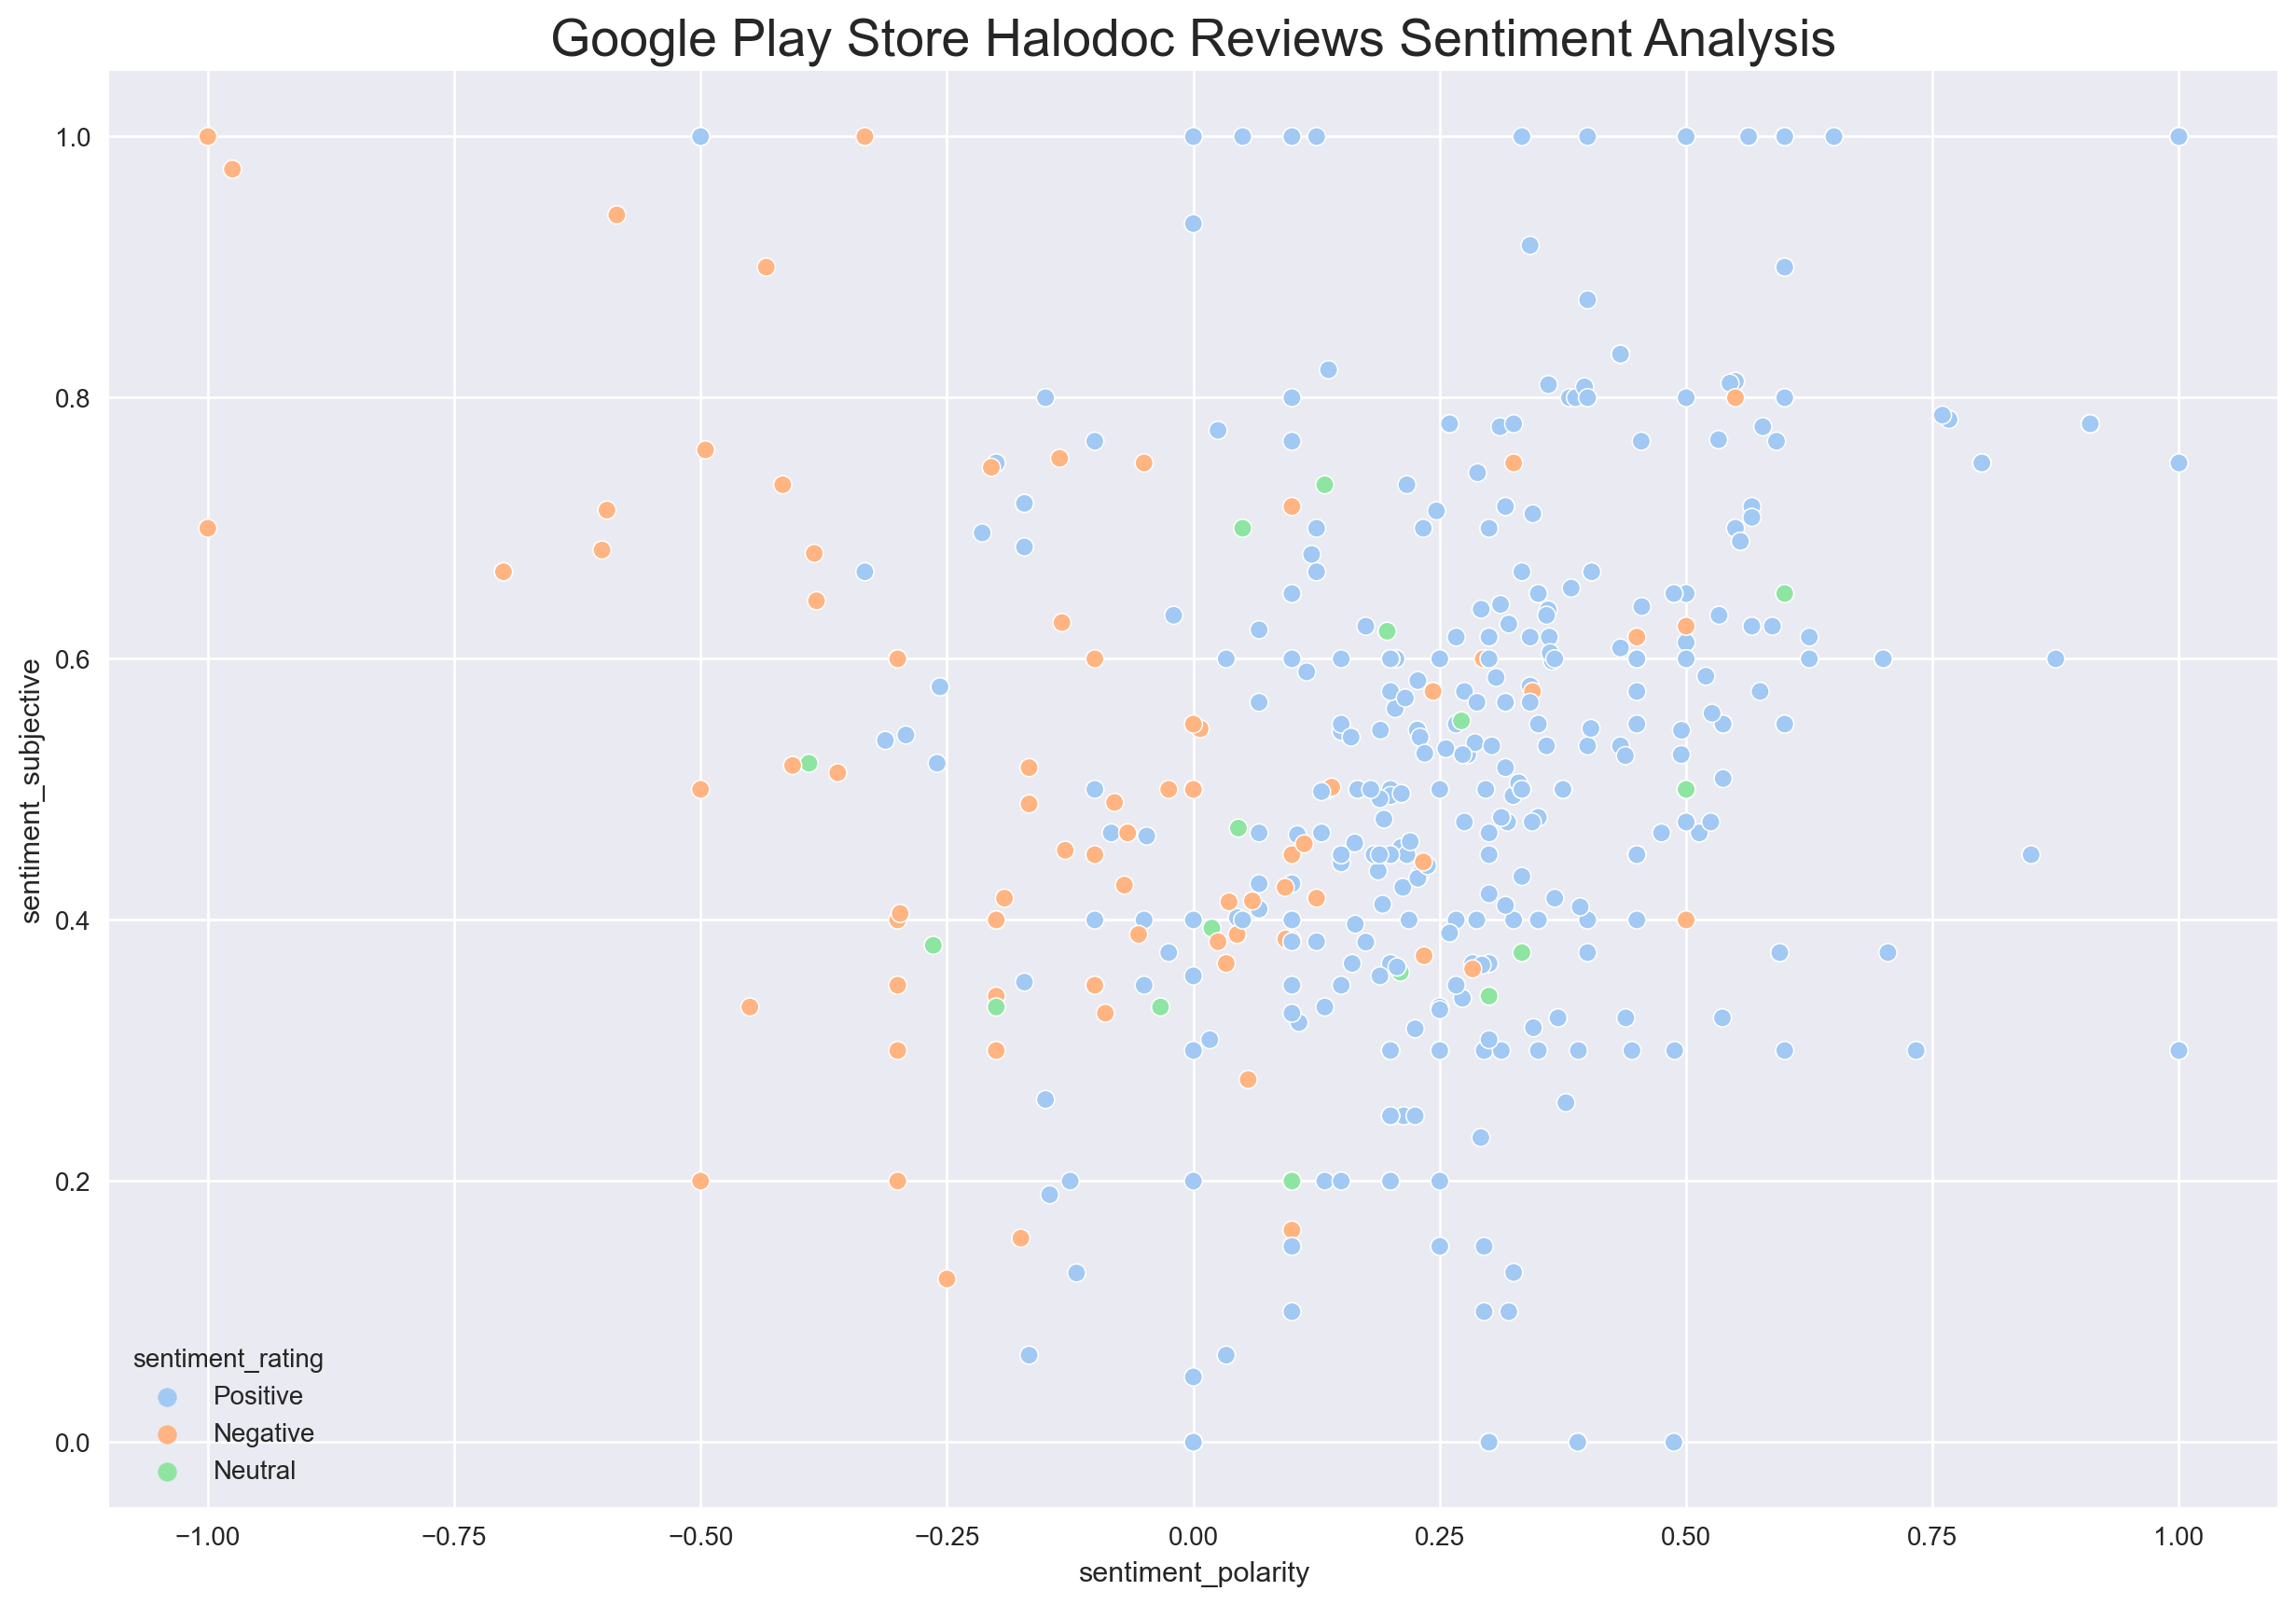

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.scatterplot(df_hdrev['sentiment_polarity'], df_hdrev['sentiment_subjective'],
                hue = df_hdrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Halodoc Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [178]:
#Print the extracted emojis review column (content) before stopwords
df_hdrev.to_csv(r'df_halodoc_before_stopwords_sentiment_rating.csv', index=False)

## Step 4 - Additional Cleaning Text (Remove Another Special Text) 

In [179]:
#function for counting words in halodoc reviews
def word_count(text: str) -> int:
  return len(text.split())

In [180]:
#make a new df that saved df_hdrev['content'] value to make a comparison 
df_hdrev2 = df_hdrev[['content']].copy()
df_hdrev2['n_words'] = df_hdrev['content'].apply(word_count)

In [181]:
import re
import string

def cleaning_text(text):
  # Menambah spasi setelah koma pada koma yang tidak diberi spasi
  text = re.sub(r",(?!\s)", ", ", text)
  # Menghapus tab, new line, back slice, dll
  text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
  # Menghapus karakter non ASCII (emoticon, chinese word, dll),
  text = text.encode('ascii', 'replace').decode('ascii')
  # Menghapus URL
  text = re.sub(r"(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?", "", text)
  # Menghapus angka
  text = re.sub(r"\d+", "", text)
  # Menghapus tanda baca
  text = text.translate(str.maketrans("", "", string.punctuation))
  # Menghapus whitespace di depan/belakang teks dan double++ spasi
  text = text.strip()
  text = re.sub('\s+', ' ', text)
  # Menghapus single character
  return re.sub(r"\b[a-zA-Z]\b", "", text)

In [182]:
df_hdrev2['clean'] = df_hdrev2['content'].apply(cleaning_text)
df_hdrev2['count_clean'] = df_hdrev2['clean'].apply(word_count)

## Step 5 - Remove New Stopwords

In [183]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english') + ['the', "very", "to", "and", "is", "i",
                                     "it", "a", "for", "you", "in", "this", "of",
                                     "be", "with", "was", "so", "are", "but", 
                                     "it's", "someone","still","would","need", ".", ","]
print(f"There are {len(stop)} total of stopwords in English")
print(f"Examples are: {stop[:10]}")

There are 205 total of stopwords in English
Examples are: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [184]:
# Exclude stopwords
df_hdrev2['review_without_stopwords'] = df_hdrev2['clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [185]:
df_hdrev2['count_without_stopwords'] = df_hdrev2['review_without_stopwords'].apply(word_count)


In [186]:
df_hdrev2 = df_hdrev2.loc[:,["content","n_words","clean","count_clean", "review_without_stopwords","count_without_stopwords"]]

In [160]:
df_hdrev2.head()

,content,n_words,clean,count_clean,review_without_stopwords,count_without_stopwords
16286,nice and helpful doctor...god bless,5,nice and helpful bless,4,nice helpful bless,3
26624,good,1,good,1,good,1
24905,good. very helpful,3,good very helpful,3,good helpful,2
13360,"communicative doctor, have used this application several times. treatment is quite targeted",12,communicative doctor have used this application several times treatment is quite targeted,12,communicative doctor used application several times treatment quite targeted,9
96,the best way to consult a doctor in an emergency or when you can't leave the house,17,the best way to consult doctor in an emergency or when you cant leave the house,16,best way consult doctor emergency cant leave house,8


In [188]:
#Save into csv after applying stopwords
df_hdrev2.to_csv(r'df_halodoc_after_stopwords_sentiment_rating.csv', index=False)

In [189]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

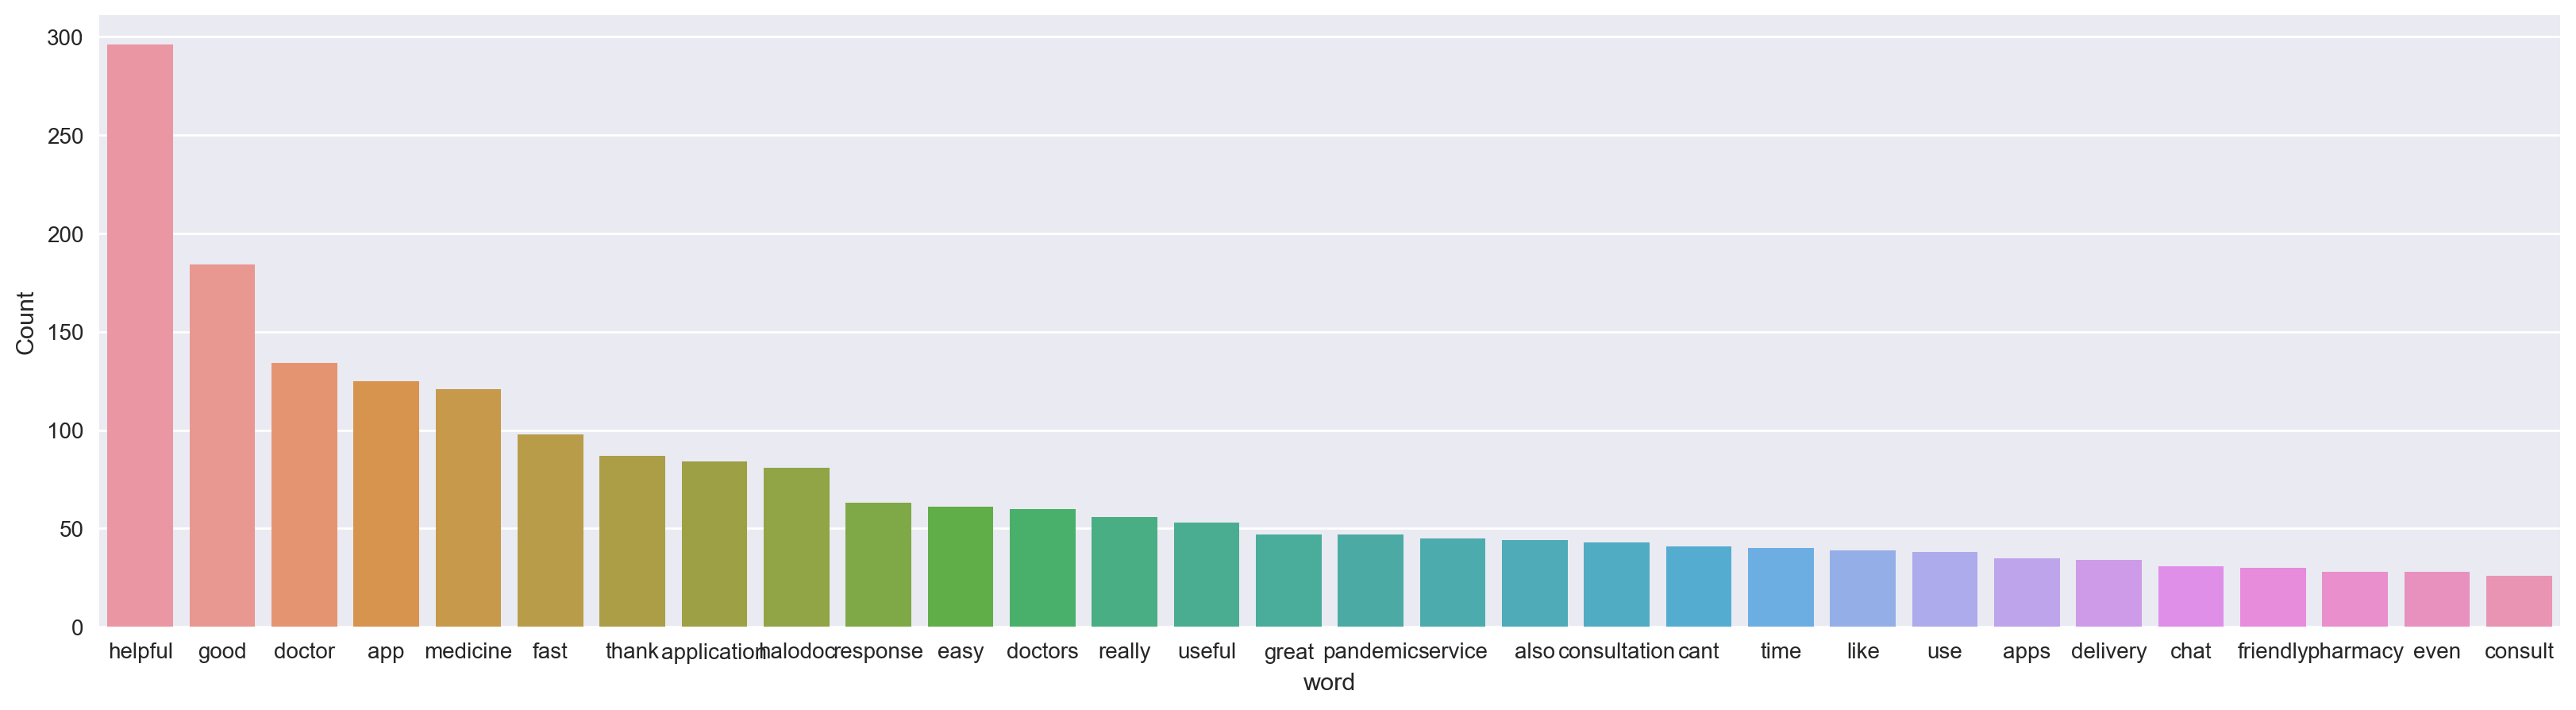

In [190]:
freq_words(df_hdrev2['review_without_stopwords'])

## Step 6 - Stemming

In [192]:
from nltk.stem import PorterStemmer
from tqdm import tqdm
nltk.download("punkt")
ps = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [193]:
def stem_text(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [194]:
df_hdrev2['stem'] = df_hdrev2['review_without_stopwords'].apply(stem_text)

In [49]:
#===BIGRAM https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5 not yet
#Creating bigram/trigram to search

In [197]:
#DROP NA
df_hdrev2.dropna(inplace=True)
df_hdrev2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 16286 to 1243
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   content                   1000 non-null   object
 1   n_words                   1000 non-null   int64 
 2   clean                     1000 non-null   object
 3   count_clean               1000 non-null   int64 
 4   review_without_stopwords  1000 non-null   object
 5   count_without_stopwords   1000 non-null   int64 
 6   stem                      1000 non-null   object
dtypes: int64(3), object(4)
memory usage: 94.8+ KB


In [198]:
df_hdrev2.head()

,content,n_words,clean,count_clean,review_without_stopwords,count_without_stopwords,stem
16286,nice and helpful doctor...god bless,5,nice and helpful bless,4,nice helpful bless,3,nice help bless
26624,good,1,good,1,good,1,good
24905,good. very helpful,3,good very helpful,3,good helpful,2,good help
13360,"communicative doctor, have used this application several times. treatment is quite targeted",12,communicative doctor have used this application several times treatment is quite targeted,12,communicative doctor used application several times treatment quite targeted,9,commun doctor use applic sever time treatment quit target
96,the best way to consult a doctor in an emergency or when you can't leave the house,17,the best way to consult doctor in an emergency or when you cant leave the house,16,best way consult doctor emergency cant leave house,8,best way consult doctor emerg cant leav hous


# Result Halodoc Review

In [199]:
def freq_words(df_column):
  all_words = ' '.join([text for text in df_column])
  all_words = all_words.split()
  fdist = FreqDist(all_words)
  return pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

In [200]:
def bar_freq_words(df, column, n = 30):
  d = df.nlargest(columns=column, n = n)
  plt.figure(figsize=(50,10))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [201]:
from nltk.probability import FreqDist

df_words = freq_words(df_hdrev2['stem']).sort_values(by=['count'], ascending=False)
df_words.head()

,word,count
1,help,363
5,doctor,194
3,good,191
36,app,160
40,medicin,133


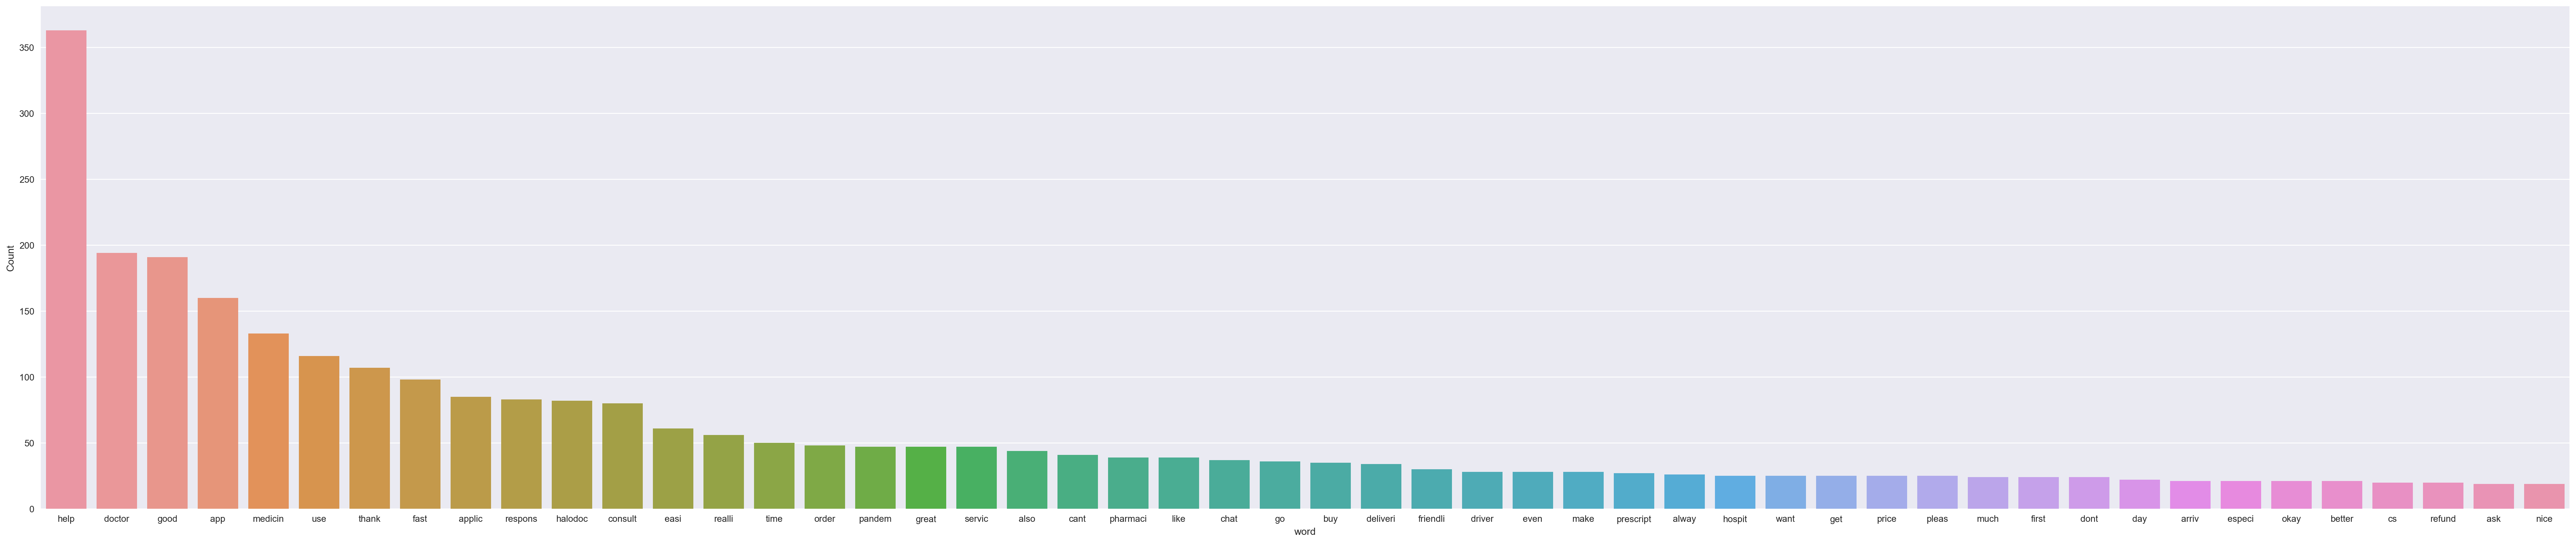

In [202]:
import seaborn as sns

bar_freq_words(df_words, 'count', 50)

## Rating Score

In [204]:
df_hdrev['score'].value_counts()

score
5    816
1     80
4     59
3     27
2     18
Name: count, dtype: int64

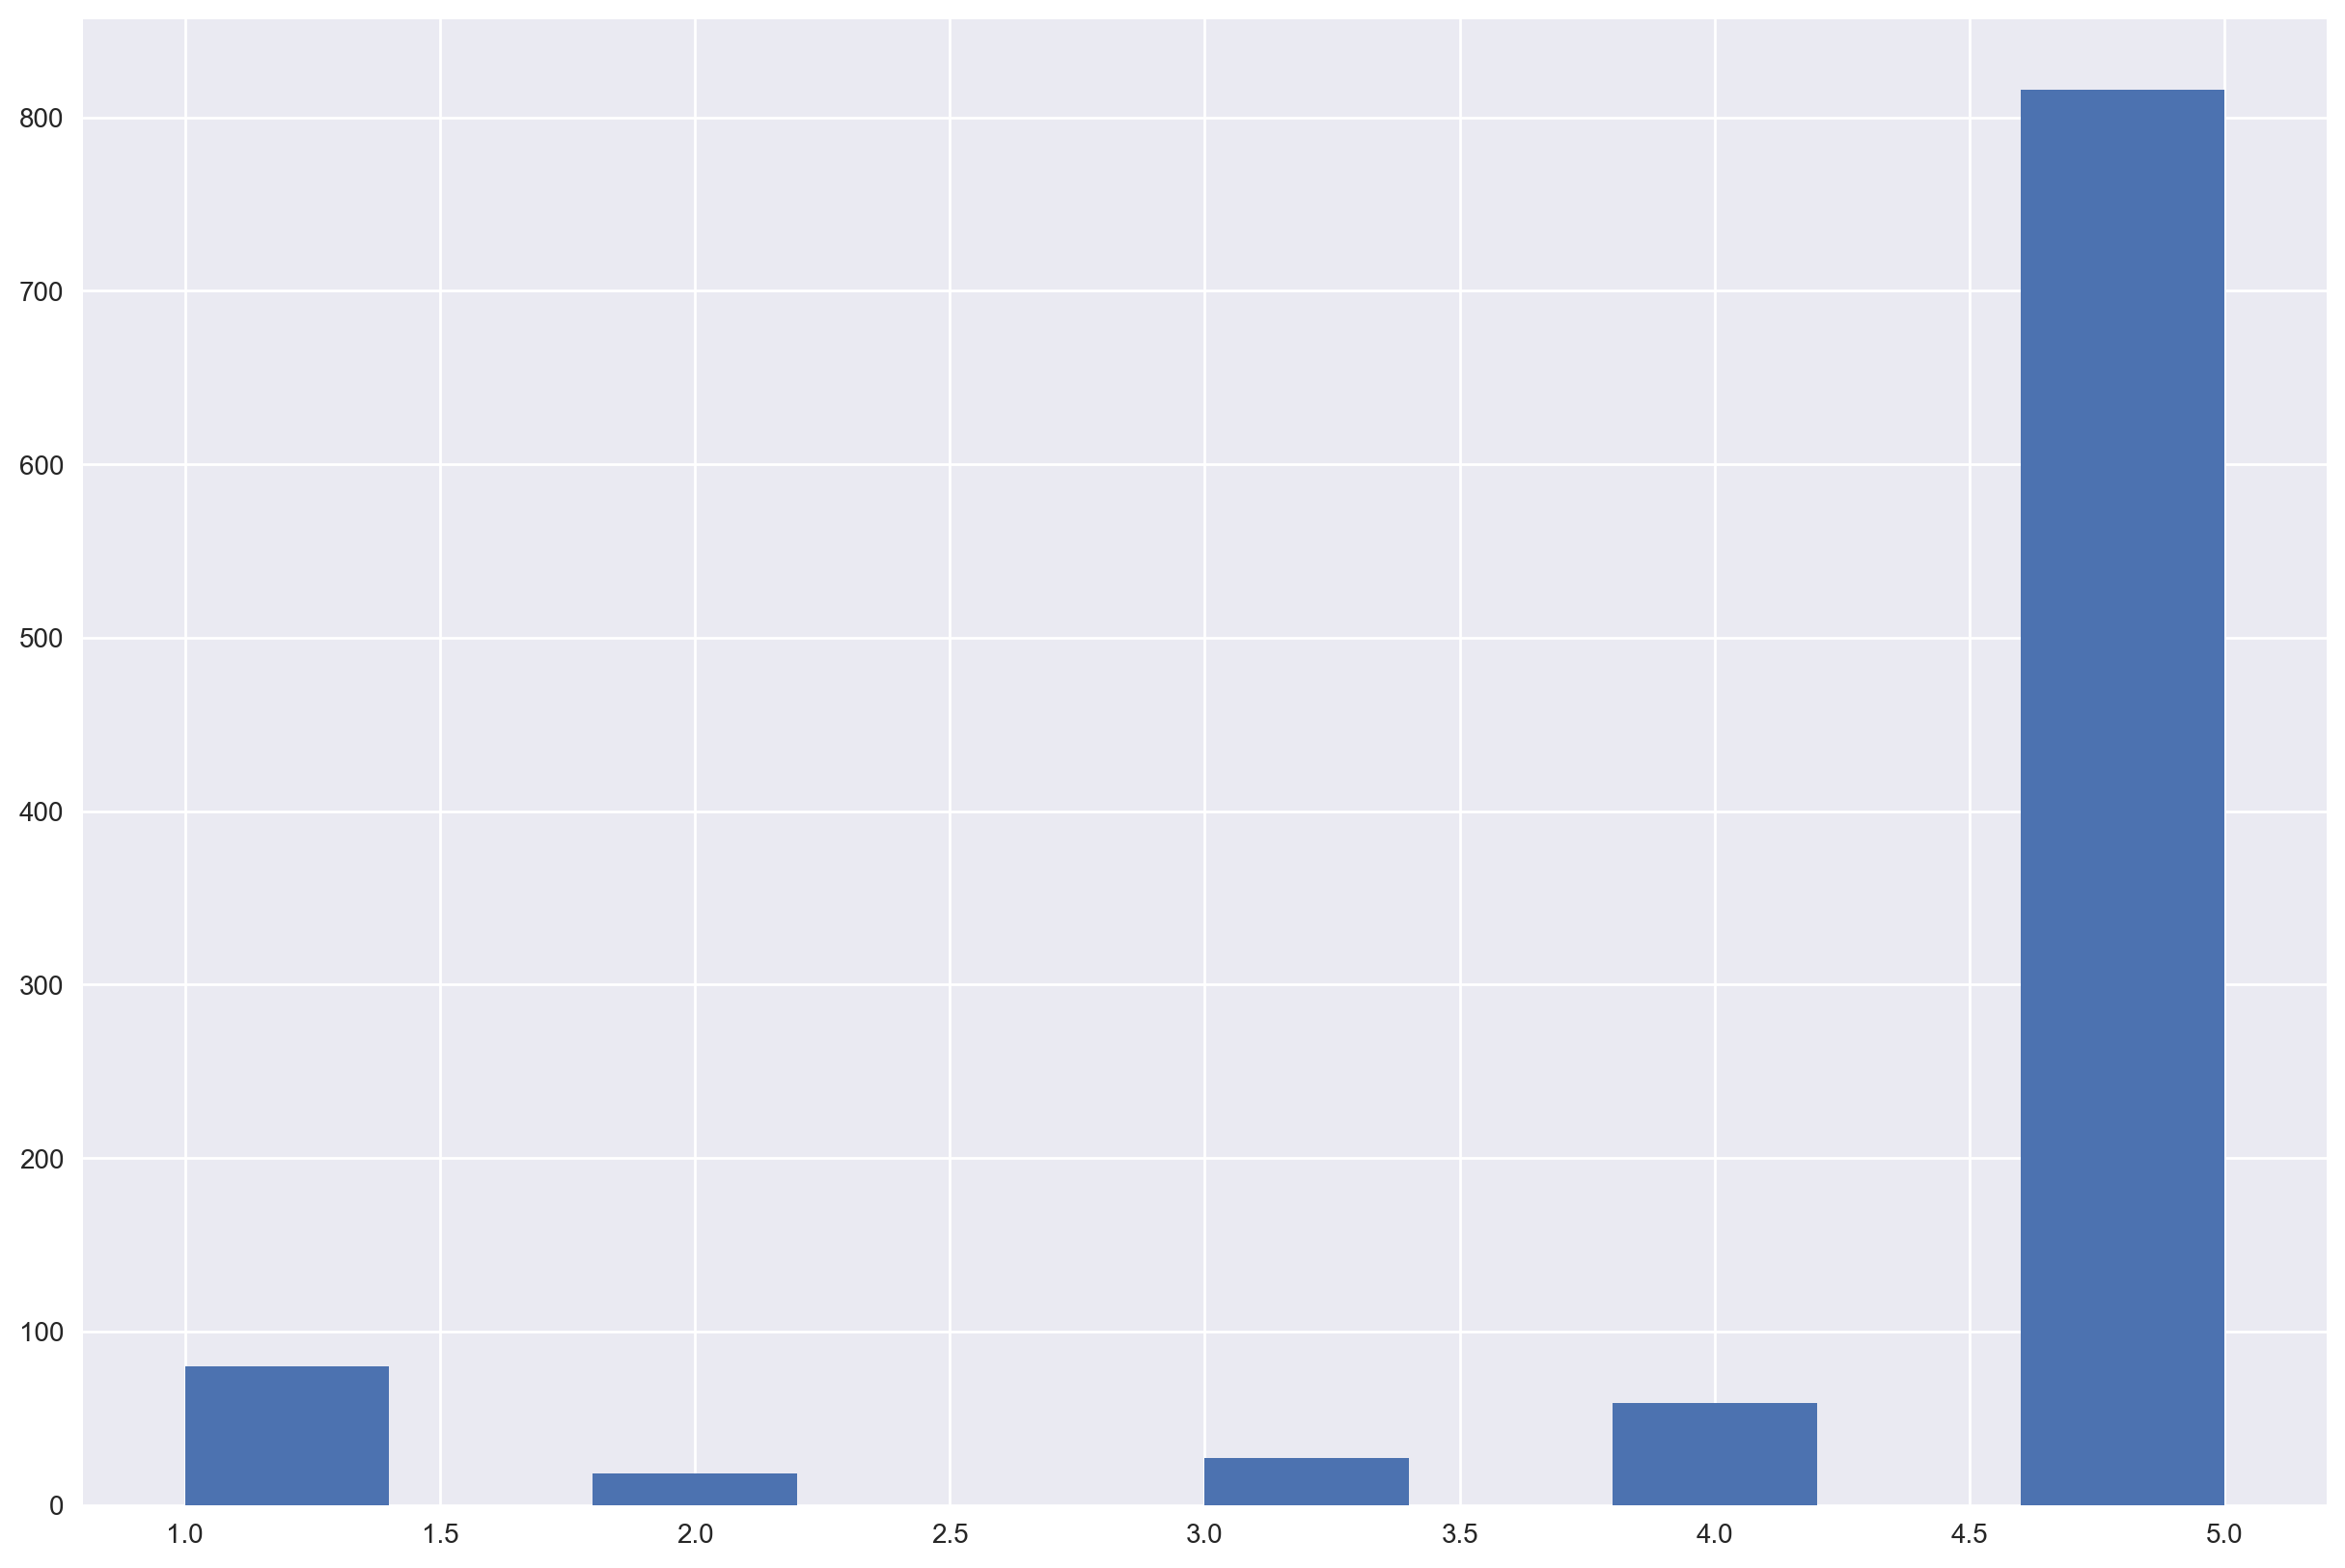

In [205]:
import matplotlib.pyplot as plt

plt.hist(df_hdrev['score'])
plt.show()

# Sentiment after Preprocessing

In [206]:
#menggunakan df_trev['no_stopwords']
from textblob import TextBlob
df_hdrev2['sentiment_polarity'] = df_hdrev2['stem'].apply(lambda x: TextBlob(x).polarity)
df_hdrev2['sentiment_subjective'] = df_hdrev2['stem'].apply(lambda x: TextBlob(x).subjectivity)

In [209]:
df_hdrev2['score'] = df_hdrev[['score']].copy()

In [211]:
df_hdrev2['sentiment_rating'] = df_hdrev2['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [214]:
df_hdrev2.loc[:,['review_without_stopwords','stem', 'score', 'sentiment_polarity', 'sentiment_subjective', 'sentiment_rating']]

,review_without_stopwords,stem,score,sentiment_polarity,sentiment_subjective,sentiment_rating
16286,nice helpful bless,nice help bless,5,0.600000,1.000000,Positive
26624,good,good,5,0.700000,0.600000,Positive
24905,good helpful,good help,5,0.700000,0.600000,Positive
13360,communicative doctor used application several times treatment quite targeted,commun doctor use applic sever time treatment quit target,5,0.000000,0.000000,Positive
96,best way consult doctor emergency cant leave house,best way consult doctor emerg cant leav hous,5,1.000000,0.300000,Positive
...,...,...,...,...,...,...
6405,complained via chat long time without answer answered repeated question example recipe right answered recipe right next chat called cs busy,complain via chat long time without answer answer repeat question exampl recip right answer recip right next chat call cs busi,1,0.130357,0.367857,Negative
24058,helpful people minimal knowledge world health doctors fast serving session love,help peopl minim knowledg world health doctor fast serv session love,5,0.350000,0.600000,Positive
26140,helpful,help,5,0.000000,0.000000,Positive
9715,processes went smoothly quick response,process went smoothli quick respons,5,0.333333,0.500000,Positive


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 16286 to 1243
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   content                   1000 non-null   object 
 1   n_words                   1000 non-null   int64  
 2   clean                     1000 non-null   object 
 3   count_clean               1000 non-null   int64  
 4   review_without_stopwords  1000 non-null   object 
 5   count_without_stopwords   1000 non-null   int64  
 6   stem                      1000 non-null   object 
 7   sentiment_polarity        1000 non-null   float64
 8   sentiment_subjective      1000 non-null   float64
 9   score                     1000 non-null   int64  
 10  sentiment_rating          1000 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 126.0+ KB


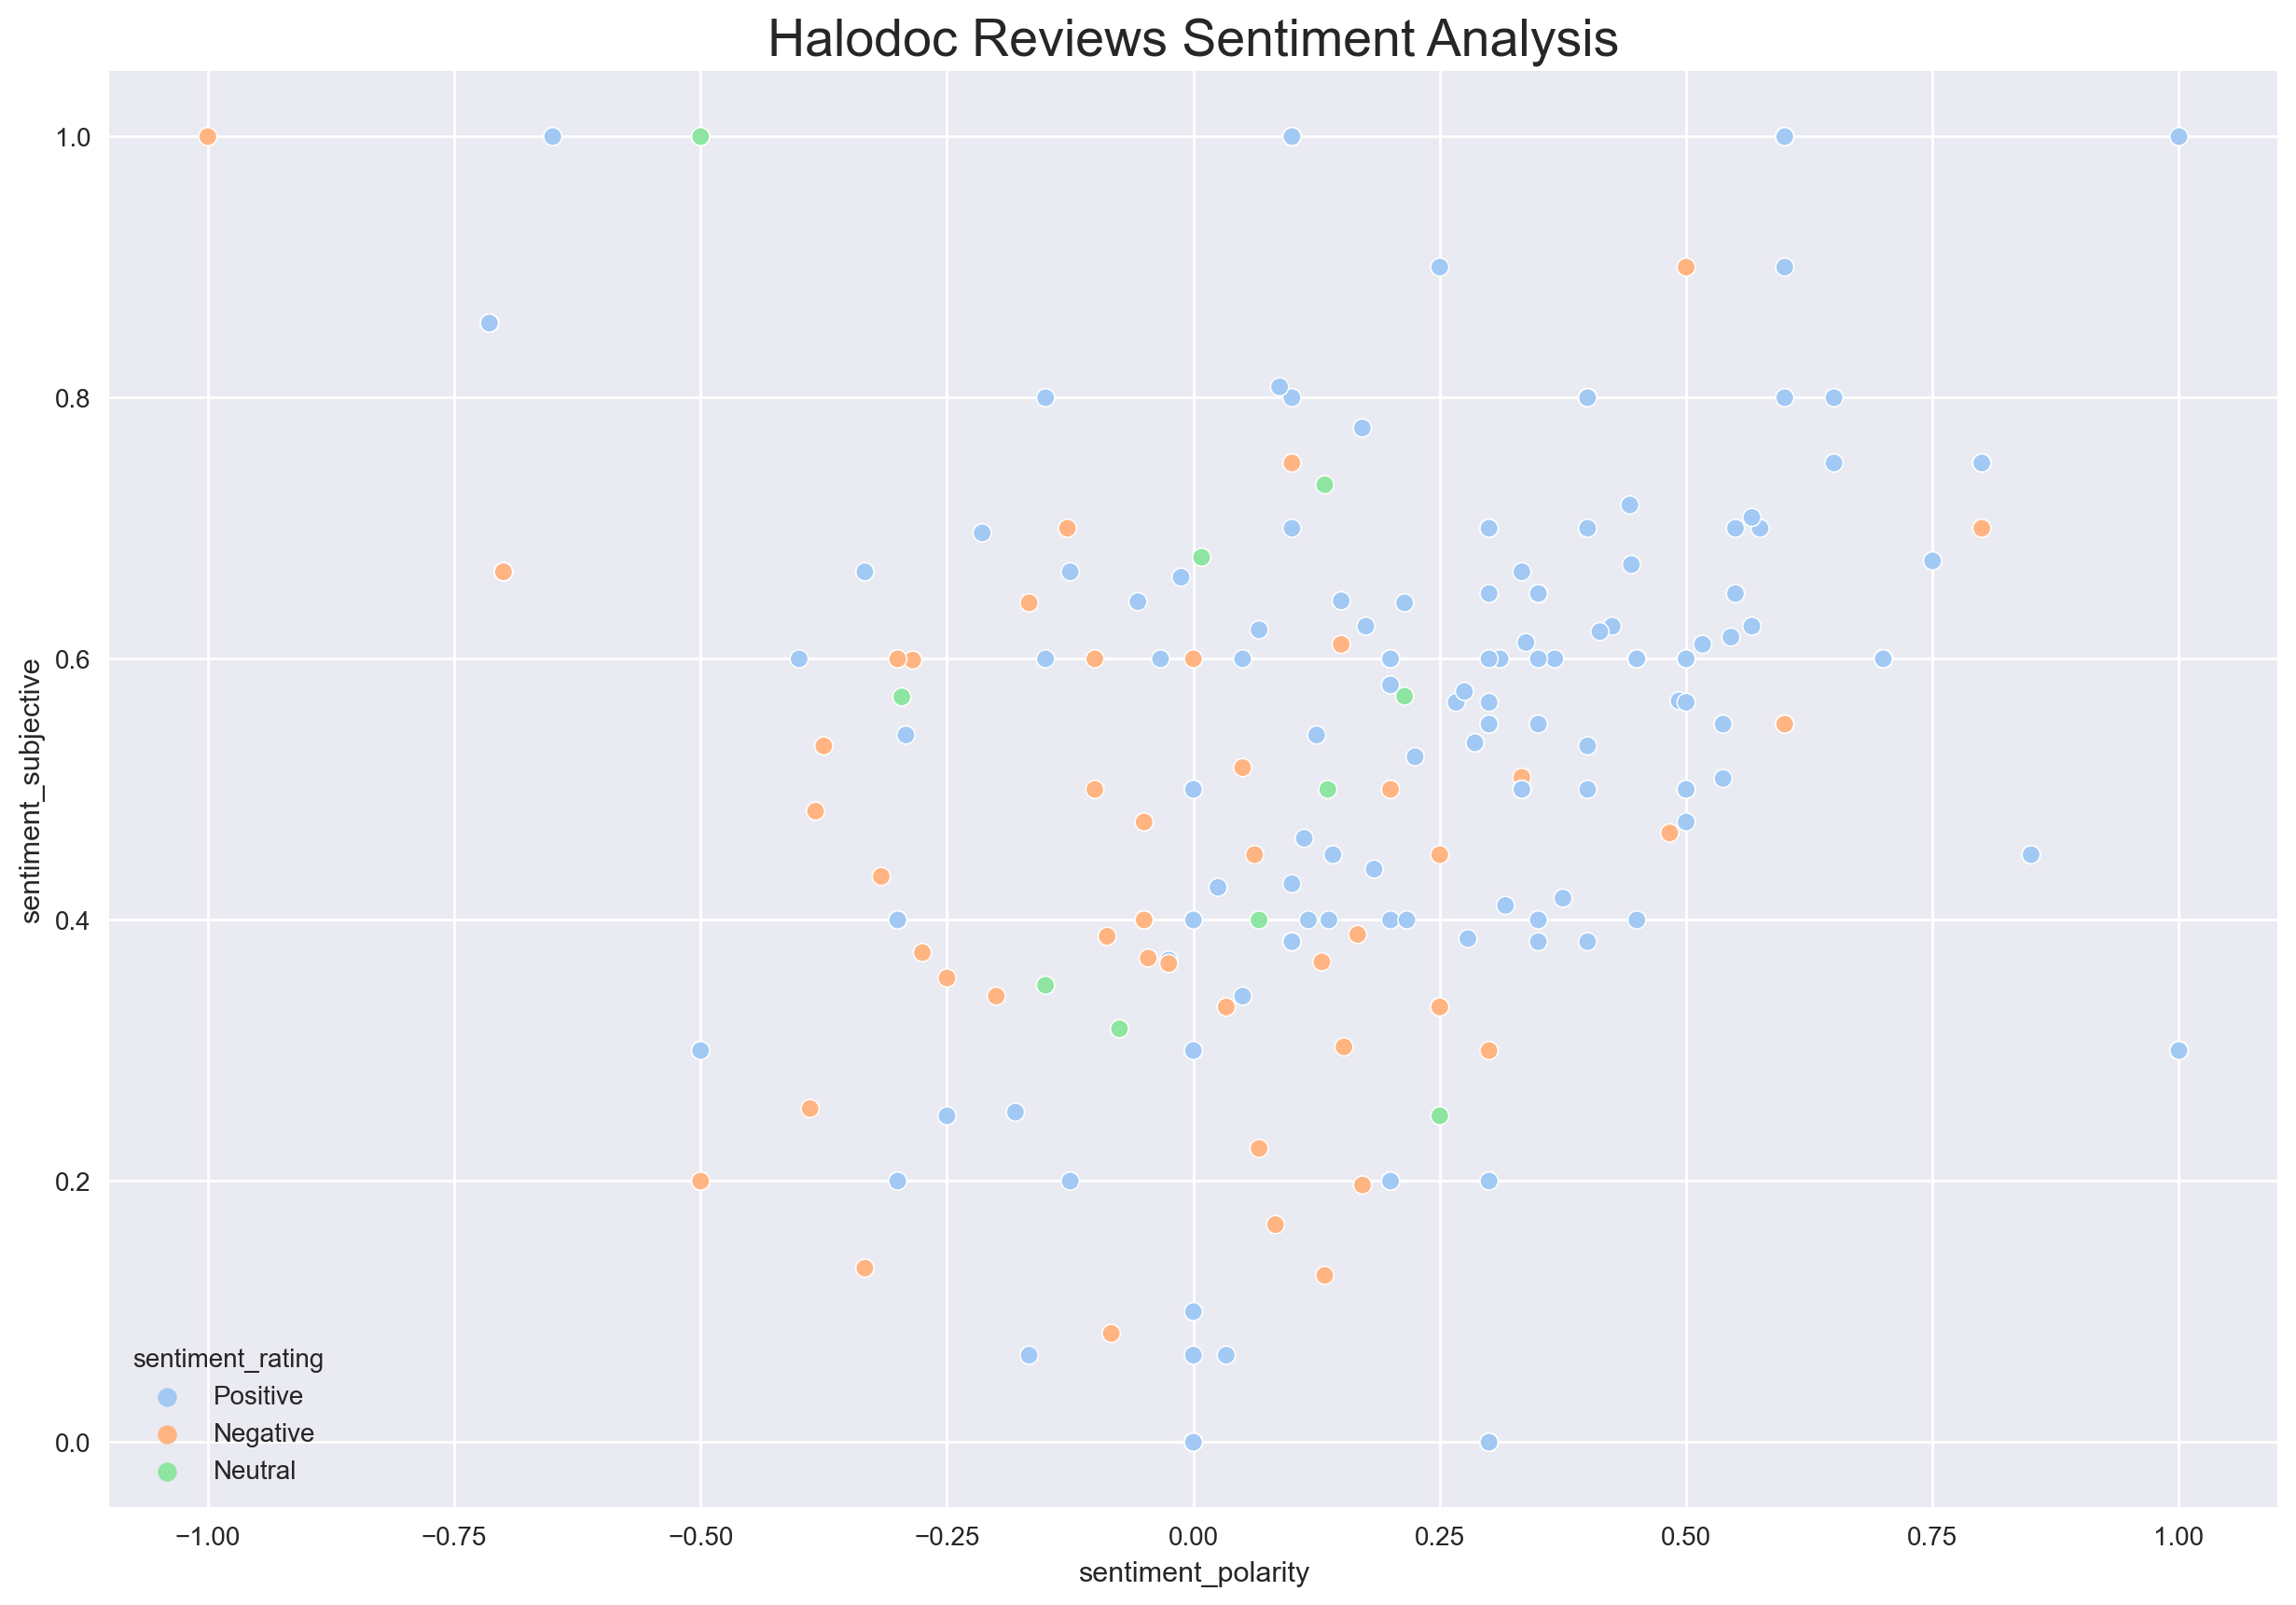

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

df_hdrev2.info()


sns.scatterplot(
    data=df_hdrev2,
    x='sentiment_polarity',
    y='sentiment_subjective',
    hue='sentiment_rating',
    edgecolor='white',
    palette="pastel"
)

plt.title("Halodoc Reviews Sentiment Analysis", fontsize=20)

plt.show()